2023 Bart Smeets

# Process raw data

This code processes raw z-scan data such that it can be used for further analysis.

Its functionalities are:

- Average multiple measurements
- Calculate errorbars
- Normalise data
- Export separate Open Aperture and Closed Aperture processed data files

## Imports

- Import the necessary packages

In [ ]:
# Python standard library
from datetime import datetime
import tkinter as tk
from tkinter import filedialog
import os

# Required
from scipy.signal import find_peaks, peak_widths
import numpy as np
import pandas as pd
from sklearn.linear_model import HuberRegressor
import matplotlib.pyplot as plt

## Load data

- Create window for file selection
- Store data in data structure:

    0. Index 0 controls the individual measurements
    1. Index 1 controls the number of data points within an individual measurement
    2. Index 2 stores the different types of data of an individual measurement at a specific data point:
        * index 2 = 0: z-data
        * index 2 = 1: open aperture
        * index 2 = 2: closed aperture
        
- Average data of individual measurements


In [132]:
# Set initial directory
INITIAL_PATH = os.environ.get('HOMEPATH')

# Create window for file selection
root = tk.Tk()
root.withdraw()
root.attributes('-topmost', True)
FILE_NAMES = filedialog.askopenfilenames(initialdir=INITIAL_PATH, title='Select Data Files')
root.destroy()

# Change working directory
## Directory is the folder where the selected files are located
index = FILE_NAMES[0].rfind('/')
DIRECTORY = FILE_NAMES[0][:index]
os.chdir(DIRECTORY)

# Data loading
N_MEASUREMENTS = len(FILE_NAMES)
for i in range(N_MEASUREMENTS):
    data = np.loadtxt(FILE_NAMES[i])
    ## At the first iteration, initialise data structure
    if i == 0:    
        N_DATAPOINTS = len(data[:,0])
        DATA = np.ndarray((N_MEASUREMENTS, N_DATAPOINTS, 3))    # 0: measurement; 1: data point; 2: data type
    ## Store data in data structure
    DATA[i, :, 0] = np.abs(data[:,0])
    DATA[i, :, 1] = data[:, 1]
    DATA[i, :, 2] = data[:, 2]

## Plot unprocessed data

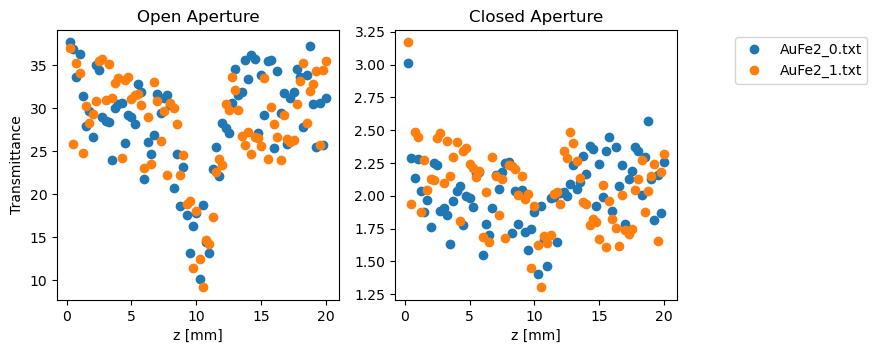

In [133]:
fig, ax = plt.subplots(1, 2, figsize=(8,3.5))

# Plot individual measurements
for i in range(N_MEASUREMENTS):
    file_name = FILE_NAMES[i]
    ax[0].plot(DATA[i, :, 0], DATA[i, :, 1], 'o', label=file_name[index+1:])
    ax[1].plot(DATA[i, :, 0], DATA[i, : , 2], 'o')
# Label axes
ax[0].legend(bbox_to_anchor=(2.9,1))
ax[0].set_title('Open Aperture')
ax[0].set_xlabel('z [mm]')
ax[0].set_ylabel('Transmittance')
ax[1].set_title('Closed Aperture')
ax[1].set_xlabel('z [mm]')

plt.show()

## Normalise data

- Normalise the data with respect to the farfield

To determine the baseline, it uses the Huber regression model, which is a linear regression model that is robust to outliers, see https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.HuberRegressor.html

In [134]:
def normalise(data):

    # Locate peaks
    peaks, p_properties = find_peaks(data, prominence=0)
    if len(p_properties['prominences']) != 0:
        peak = peaks[np.argmax(p_properties['prominences'])]
        p_prominence = np.max(p_properties['prominences'])
    else:
        p_prominence = 0

    # Locate valleys
    valleys, v_properties = find_peaks(-data, prominence=0)
    if len(v_properties['prominences']) != 0:
        valley = valleys[np.argmax(v_properties['prominences'])]
        v_prominence = np.max(v_properties['prominences'])
    else:
        v_prominence = 0

    # Check if peak or valley is more prominent
    if p_prominence > v_prominence:
        width = peak_widths(data, [peak], 1 - 0.135)
    else:
        width = peak_widths(-data, [valley], 1 - 0.135)

    # Find boundary indices of peak or valley
    left_index = int(width[2])
    right_index = int(width[3])

    # Compute baseline
    baseline = np.append(data[:left_index], data[right_index:])
    normalisation = np.average(baseline)

    return normalisation

In [136]:
# Initialise data structures
DATA_AVERAGE_NORM = np.ndarray((N_DATAPOINTS, 3))
DATA_NORM = np.ndarray((N_MEASUREMENTS, N_DATAPOINTS, 3))
MAE_NORM = np.ndarray((N_DATAPOINTS,2))


# Normalise data and store in data structure
## Store z-position
DATA_AVERAGE_NORM[:, 0] = DATA[0, :,0]
DATA_NORM[:,:,0] = DATA[:,:,0]
## Store normalised open and closed aperture and errorbars
for i in [1, 2]:
    for j in range(N_MEASUREMENTS):
        normalisation = normalise(DATA[j, :, i])
        DATA_NORM[j,:, i] = DATA[j,:, i] / normalisation


# Average
for i in range(N_DATAPOINTS):
    ## Calculate average
    OA_averge = np.average(DATA_NORM[:, i, 1])
    CA_averge = np.average(DATA_NORM[:, i, 2])
    ## Store average in data structure
    DATA_AVERAGE_NORM[i, 1] = OA_averge
    DATA_AVERAGE_NORM[i, 2] = CA_averge


# Error
MAE_NORM = np.ndarray((N_DATAPOINTS, 2))    # Initialise data structure
## Calculate the MAE for every data point
for i in range(N_DATAPOINTS):    
    MAE_NORM[i, 0] = np.sum(np.abs(DATA_NORM[:, i, 1] - DATA_AVERAGE_NORM[i,1])) / N_MEASUREMENTS
    MAE_NORM[i, 1] = np.sum(np.abs(DATA_NORM[:, i, 2] - DATA_AVERAGE_NORM[i,2])) / N_MEASUREMENTS

## Plot normalised data

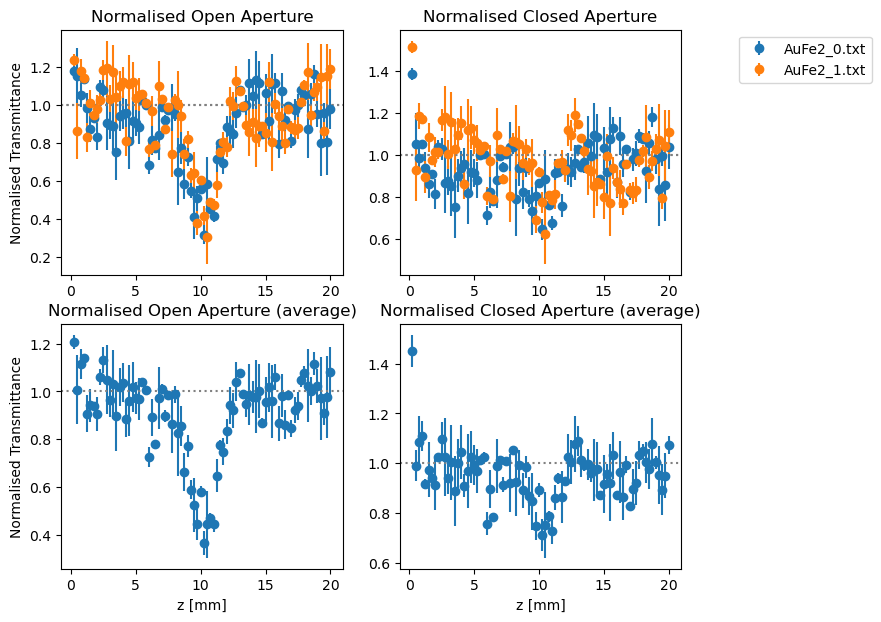

In [137]:
fig1, ax1 = plt.subplots(2, 2, figsize=(8,7))

# Plot individual measurements
for i in range(N_MEASUREMENTS):
    file_name = FILE_NAMES[i]
    ax1[0,0].errorbar(DATA_NORM[i, :, 0], DATA_NORM[i, :, 1], MAE_NORM[:,0], fmt='o', label=file_name[index+1:])
    ax1[0,1].errorbar(DATA_NORM[i, :, 0], DATA_NORM[i, : , 2], MAE_NORM[:,0], fmt='o')
    ax1[0,0].axhline(1, ls=':', color='grey')
    ax1[0,1].axhline(1, ls=':', color='grey')
# Plot average of measurements
ax1[1,0].errorbar(DATA_AVERAGE_NORM[:,0], DATA_AVERAGE_NORM[:,1], MAE_NORM[:,0], fmt='o')    # Open aperture
ax1[1,1].errorbar(DATA_AVERAGE_NORM[:,0], DATA_AVERAGE_NORM[:,2], MAE_NORM[:,1], fmt='o')    # Closed aperture
ax1[1,0].axhline(1, ls=':', color='grey')
ax1[1,1].axhline(1, ls=':', color='grey')
# Label axes
ax1[0,0].legend(bbox_to_anchor=(2.9,1))
ax1[0,0].set_title('Normalised Open Aperture')
ax1[1,0].set_title('Normalised Open Aperture (average)')
ax1[1,0].set_xlabel('z [mm]')
ax1[0,0].set_ylabel('Normalised Transmittance')
ax1[1,0].set_ylabel('Normalised Transmittance')
ax1[0,1].set_title('Normalised Closed Aperture')
ax1[1,1].set_title('Normalised Closed Aperture (average)')
ax1[1,1].set_xlabel('z [mm]')

plt.show()

## Export normalised data

- Export results in text-file
- Export figures
- Generate INPUT_PARAMETERS.csv

In [ ]:
# Create export directory
timeCode = datetime.now()
EXPORT_FOLDER = "/Normalised_Data_" + timeCode.strftime("%Y%m%d-%H%M%S")
EXPORT_DIRECTORY = DIRECTORY + EXPORT_FOLDER
os.mkdir(EXPORT_DIRECTORY)


# Save figures
fig.savefig(EXPORT_DIRECTORY + '/OUTPUT_RAW_DATA.png', bbox_inches='tight')
fig1.savefig(EXPORT_DIRECTORY + '/OUTPUT_NORMALISED_DATA.png', bbox_inches='tight')

# Generate input file containing all parameters necessary for zscan-fit
INPUT_FILE = pd.DataFrame({'Wavelength': ['[nm]', 0], 'Pulse Energy': ['[uJ]',0], 'zR': ['[um]',0], 'W0': ['[um]',0], 'alpha': ['[cm-1]',0], 'L': ['[cm]',0]}, index=['unit', 'value'])
INPUT_FILE.to_csv(EXPORT_DIRECTORY + '/INPUT_PARAMETERS.csv', sep=';', index=False)


# Intialise Open Aperture Data
OA_EXPORT = np.ndarray((N_DATAPOINTS, 3))    # 0: z-position; 1: average OA; 2: errorbar
OA_EXPORT[:, 0] = DATA_AVERAGE_NORM[:,0]
OA_EXPORT[:, 1] = DATA_AVERAGE_NORM[:, 1]
OA_EXPORT[:, 2] = MAE_NORM[:, 0]
OA_STRING = EXPORT_DIRECTORY + '/DATA_OA_AVERAGE.txt'

# Intialise Closed Aperture Data
CA_EXPORT = np.ndarray((N_DATAPOINTS, 3))    # 0: z-position; 1: average OA; 2: errorbar
CA_EXPORT[:, 0] = DATA_AVERAGE_NORM[:,0]
CA_EXPORT[:, 1] = DATA_AVERAGE_NORM[:, 2]
CA_EXPORT[:, 2] = MAE_NORM[:, 1]
CA_STRING = EXPORT_DIRECTORY + '/DATA_CA_AVERAGE.txt'

# Export Files
np.savetxt(OA_STRING, OA_EXPORT)
np.savetxt(CA_STRING, CA_EXPORT)

# Export normalised data of individual measurements
for i in range(N_MEASUREMENTS):
    ## Initialise data structure
    file_oa_export = np.ndarray((N_DATAPOINTS, 3))
    file_ca_export = np.ndarray((N_DATAPOINTS, 3))
    ## Prepare file name
    file_name = FILE_NAMES[i]
    file_oa_string = EXPORT_DIRECTORY + '/DATA_OA_' + file_name[index+1:]
    file_ca_string = EXPORT_DIRECTORY + '/DATA_CA_' + file_name[index+1:]
    ## Store data in data structure
    ### 0: z-position; 1: average OA; 2: errorbar
    file_oa_export[:, 0] = DATA_NORM[i, :, 0]
    file_oa_export[:, 1] = DATA_NORM[i, :, 1]
    file_oa_export[:, 2] = MAE_NORM[:, 0]
    file_ca_export[:, 0] = DATA_NORM[i, :, 0]
    file_ca_export[:, 1] = DATA_NORM[i, :, 2]
    file_ca_export[:, 2] = MAE_NORM[:, 1]
    ## Export data
    np.savetxt(file_oa_string, file_oa_export)
    np.savetxt(file_ca_string, file_ca_export)


# Open output folder
os.startfile(EXPORT_DIRECTORY)